Import the neccessary libaries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore")

Data Collection (Chevron Stock)

In [3]:
# Define the stock ticker (Chevron) and the date range
TICKER = "CVX"
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"

In [ ]:
print(f"----- Downloading Historical Stock Data for Chevron -----")
# Use yf.download to pull historical stock price data
# We only use the "Close" price for prediction as it accounts for dividend and splits
data = yf.download(TICKER,start=START_DATE,end=END_DATE)

----- Downloading Historical Stock Data for Chevron -----


[*********************100%***********************]  1 of 1 completed


In [7]:
# Check the first few rows of the downloaded data
data.head()

Price,Close,High,Low,Open,Volume
Ticker,CVX,CVX,CVX,CVX,CVX
Date,,,,,
2020-01-02,93.955620,94.110366,93.444947,93.475897,5205000
2020-01-03,93.630661,94.953761,93.421747,94.226441,6360900
2020-01-06,93.313408,94.141313,93.104500,93.808603,9953000
2020-01-07,92.121857,92.640269,91.123727,92.090906,7856900
2020-01-08,91.069565,92.145067,91.030881,91.727251,7295900


Data Preprocessing

In [8]:
# Check for missing values
data_missing = data.isnull().sum()
print("----- Missing Values -----")
print(data_missing)

----- Missing Values -----
Price   Ticker
Close   CVX       0
High    CVX       0
Low     CVX       0
Open    CVX       0
Volume  CVX       0
dtype: int64


In [9]:
# Check for duplicated rows
data_duplicated = data.duplicated().sum()
print("----- Duplicated Rows -----")
print(data_duplicated)

----- Duplicated Rows -----
0


Feature Engineering

In [11]:
# The goal is to predict the price on "day N" using information from "day N-1", N-2 etc
# This converts the time-series problem into a standard supervised problem

# Target Variable (y): The price we want to predict (Close shifted one daya forward)
# We shift the target up by -1 to predict the next day's price
data["Target"] = data["Close"].shift(-1)

In [12]:
# Feature (X): Lagged prices (past day prices) and moving averages (trend indicators)
# Feature 1: Price 1 day ago (lag 1)
data["Lag_1"] = data["Close"].shift(1)

# Feature 2: Price days ago (lag 7, roughly a week)
data["Lag_7"] = data["Close"].shift(7)

In [13]:
# Feature 3: 5-Day Simple moving average (SMA - short term trend)
data["SMA_5"] = data["Close"].rolling(window=5).mean()

# Feature 4: 20-Day Simple moving average (SMA - medium term trend)
data["SMA_20"] = data["Close"].rolling(window=20).mean()

In [14]:
# Drop rows with NaN values created by shifting and rolling calculations
# The first 20 days will have NaNs due to SMA_20, which is necessary to drop.
data.dropna(inplace=True)

In [15]:
# Define the features (X) and the target (y)
features = ["Lag_1","Lag_7","SMA_5","SMA_20"]
X = data[features]
y = data["Target"]

Data Visualization before training

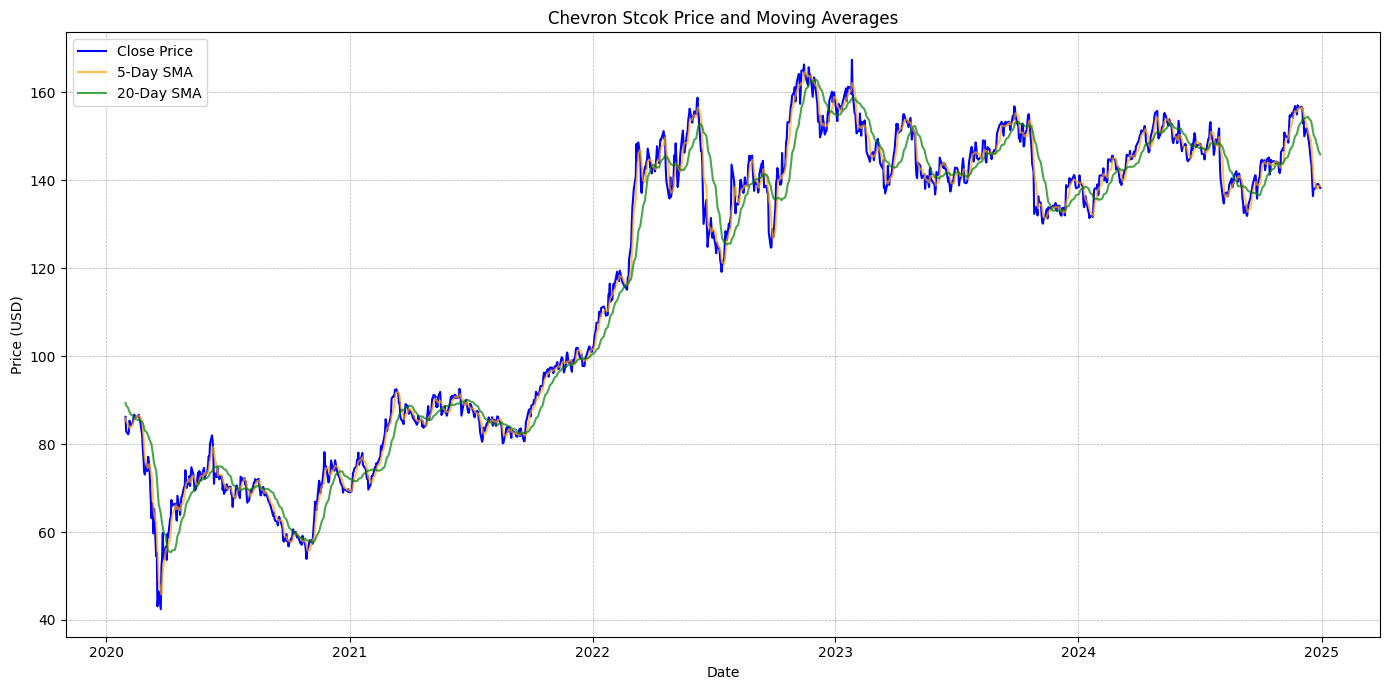

In [16]:
plt.figure(figsize=(14,7))
# Plot the historical Close price
plt.plot(data.index,data["Close"],label="Close Price",color="blue")
# Plot the 5-day moving average to show the short term trend
plt.plot(data.index,data["SMA_5"],label="5-Day SMA",color="orange",alpha=0.7)
# Plot the 20-day moving average to show the medium-term trend
plt.plot(data.index,data["SMA_20"],label="20-Day SMA",color="green",alpha=0.7)
plt.title("Chevron Stcok Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True,which="both",linestyle="--",linewidth=0.5)
# Use tight_layout to ensure all elemnts fit the plot area
plt.tight_layout()
plt.show() # Display the plot

Data Splitting

In [23]:
# Split the data into training and testing sets
# Using a time-series split (no shuffling) is cruical for financial data
# We'll use 80% for training and 20% for testing

split_point = int(len(X) * 0.8)
X_train,X_test = X[:split_point],X[split_point:]
y_train,y_test = y[:split_point],y[split_point:]

print(len(X_train))

990


Data Scaling

In [24]:
# Initialize the Standard Scaler, Scaling is essential for Linear , Ridge and Lasso
scaler = StandardScaler()

# Fit the scaler only on the training data to prevent data leakage
X_train_scaled = scaler.fit_transform(X_train)
# Apply the fitted scaler to the test data
X_test_scaled = scaler.transform(X_test)

Model Definition and Tuning

In [25]:
# Dictionary to store all models and their best parameters/performance
models = {
    "Linear Regression":LinearRegression(),
    # Ridge and Lasso require scaled data
    "Ridge Regression (Tuned)":Ridge(random_state=42),
    "Lasso Regression":Lasso(random_state=42),
    # Random Forest is an ensemle method and generally robust to unscaled data
    # but scaling doesn't hurt
    "Random Forest Regressor (Tuned)": RandomForestRegressor(random_state=42)
}

In [27]:
# Hyperparameter Tuning using GridSearchCV

# Tune Ridge Regression
# Define the grid of alpha value (regularization strength) to search
ridge_params = {
    "alpha":[0.1,1.0,10.0,100.0]
}
# Use GridSearchCV to find the best alpha value using cross-validation (cv=5)
ridge_gs = GridSearchCV(Ridge(random_state=42),ridge_params,cv=5,scoring="neg_mean_squared_error")
# Fit the GridSearchCV on the scaled training data
ridge_gs.fit(X_train_scaled,y_train)
# Update the models dictionary with the best estimator
models["Ridge Regression (Tuned)"] = ridge_gs.best_estimator_
print(f"Best Ridge Alpha: {ridge_gs.best_params_["alpha"]}")

Best Ridge Alpha: 0.1


In [28]:
# Tune Random Forest Regressor
# Define the grid of parameters to search
rf_params = {
    # Number of trees in the forest
    "n_estimators":[50,100,200],
    # Maximum depth of the tree
    "max_depth":[None,10,20],
    # Minimum numnber of samples required to split an internal node
    "min_samples_split":[2,5]
}
# Use the GridSearchCV (it will take a longer due to the complexity of RF)
rf_gs = GridSearchCV(RandomForestRegressor(random_state=42),rf_params,cv=3,scoring="neg_mean_squared_error")
# Fit the GridSearchCV on the unscaled training data (RF is less sensitive to scaling)
rf_gs.fit(X_train,y_train)
# Update the models dictionary with the best found estimator
models["Random Forest Regressor (Tuned)"] = rf_gs.best_estimator_
print(f"Best Random Forest Params: {rf_gs.best_params_}")

Best Random Forest Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}


Model Training, Prediction and Evaluation

In [29]:
results = {}
best_rmse = float("inf")
best_model_name = ""
best_predictions = None

In [31]:
for name,model in models.items():
    print(f"----- Training {name} -----")

    # Determine which data to use (scaled for linear models, unscaled for others)
    if name in ["Linear Regression","Ridge Regression (Tuned)","Lasso Regression"]:
        X_train_fit = X_train_scaled
        X_test_predict = X_test_scaled
    else:
        # Random  Forest uses unscaled data (as tuned)
        X_train_fit = X_train
        X_test_predict = X_test

    # Train the model
    model.fit(X_train_fit,y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_predict)

    # Evaluate Performance
    # Root Mean Squared Error (RMSE): Measures the average magnitude of the errors. Lower is better
    rmse = np.sqrt(mean_absolute_error(y_test,y_pred))
    # Mean Absolute Error (MAE): Measure the average absolute error. Less sensitive to outliers than RMSE. Lower is better
    mae = mean_absolute_error(y_test,y_pred)
    # R-Squared (R2): Measures the proportion of the variance in the dependent variable that is predictable from the independent variables. Closer to 1 is better
    r2 = r2_score(y_test,y_pred)

    # Store the results
    results[name] = {
        "RMSE":rmse,
        "MAE":mae,
        "R2":r2
    }

    # Check for the best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = name
        best_predictions = y_pred


# Print Comparison Table
print("="*50)
print("REGRESSION MODEL COMPARISON  RESULTS (CVX STOCK)")
print("="*50)

# Convert results dictionary to a DataFrame for clean comparison printing
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")
print(results_df)

print(f"WINNER: The Best model is the {best_model_name} with an RMSE of {best_rmse:.4f}")
print("="*50)

----- Training Linear Regression -----
----- Training Ridge Regression (Tuned) -----
----- Training Lasso Regression -----
----- Training Random Forest Regressor (Tuned) -----
REGRESSION MODEL COMPARISON  RESULTS (CVX STOCK)
                                     RMSE       MAE        R2
Ridge Regression (Tuned)         1.429873  2.044537  0.826168
Linear Regression                1.430764  2.047087  0.825843
Random Forest Regressor (Tuned)  1.468070  2.155228  0.805292
Lasso Regression                 1.491463  2.224462  0.808400
WINNER: The Best model is the Ridge Regression (Tuned) with an RMSE of 1.4299


Visualization After Training

In [32]:
# Create a DataFrame to combine the actual test prices and the best model's predictions
plot_df = pd.DataFrame({
    "Actual Price":y_test,
    "Predicted Price":best_predictions
},index=y_test.index)

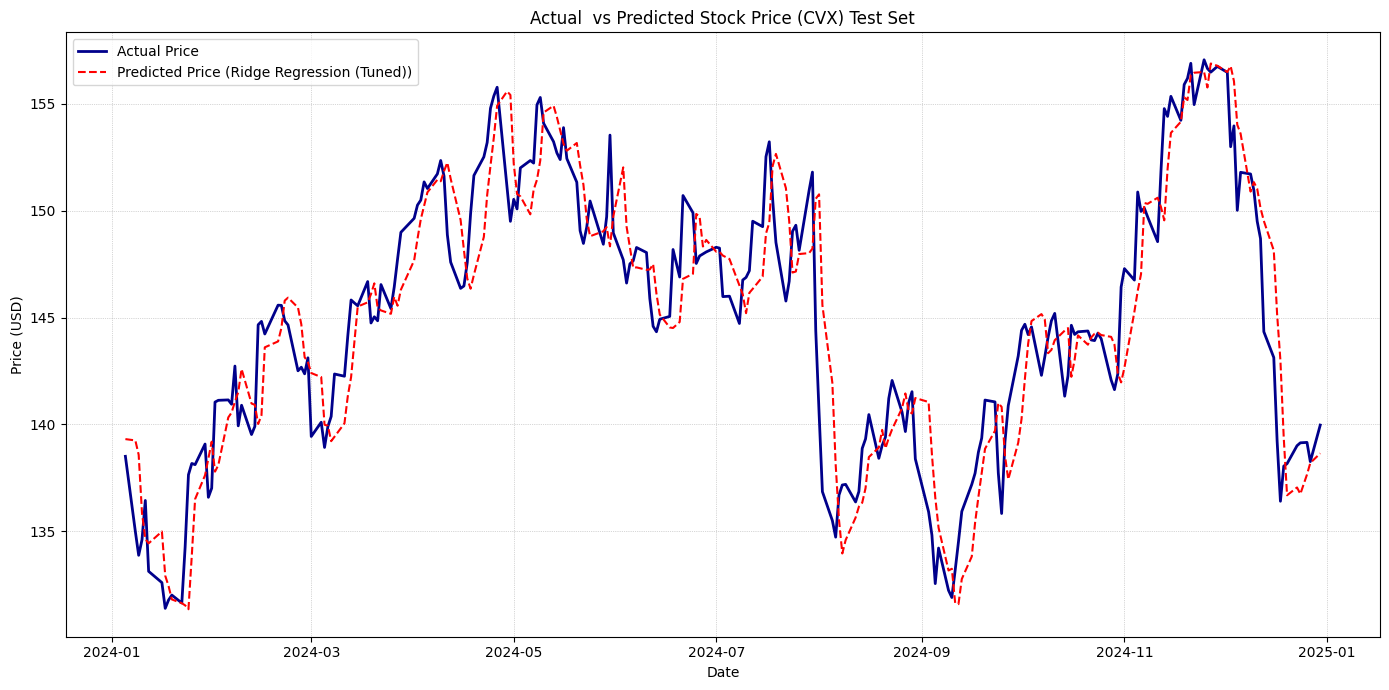

In [33]:
plt.figure(figsize=(14,7))
# Plot the actual price movements in the test set
plt.plot(plot_df.index,plot_df["Actual Price"],label="Actual Price",color="darkblue",linewidth=2)
# Plot the predicted price movements from the best model
plt.plot(plot_df.index,plot_df["Predicted Price"],label=f"Predicted Price ({best_model_name})",color="red",linestyle="--",linewidth=1.5)


plt.title(f"Actual  vs Predicted Stock Price ({TICKER}) Test Set")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True,which="both",linestyle=":",linewidth=0.5)
plt.tight_layout()
plt.show() # Display the plot

New Prediction Input Function

In [34]:
# Define the best model and scaler for external use
final_model = models[best_model_name]

# Function to predict the next day's price based on the current day's data
def predict_next_price(lag_1, lag_7, sma_5, sma_20):
    """
    Predicts the next day's stock price using the best trained model.

    Args:
        lag_1 (float): The stock price from 1 day ago.
        lag_7 (float): The stock price from 7 days ago.
        sma_5 (float): The calculated 5-day Simple Moving Average.
        sma_20 (float): The calculated 20-day Simple Moving Average.

    Returns:
        float: The predicted price for the next day.
    """
    # Create a NumPy array from the input features
    new_data = np.array([[lag_1, lag_7, sma_5, sma_20]])

    # Check if the best model is one that was trained on scaled data
    if best_model_name in ['Linear Regression', 'Ridge Regression (Tuned)', 'Lasso Regression']:
        # Scale the input data using the *fitted* scaler
        new_data_scaled = scaler.transform(new_data)
        prediction = final_model.predict(new_data_scaled)
    else:
        # Use unscaled data for models like Random Forest
        prediction = final_model.predict(new_data)

    # Return the first (and only) element of the prediction array
    return prediction[0]

In [35]:
# Example Usage of New Prediction Function:
# Using the last available data point in our original DataFrame for demonstration
last_data_point = data.iloc[-1]

# Extract the features from the last row
example_features = [
    last_data_point["Lag_1"],
    last_data_point["Lag_7"],
    last_data_point["SMA_5"],
    last_data_point["SMA_20"]
]

In [41]:
# Get the prediction for the day after the end of our dataset
#predicted_price = predict_next_price(examples_features)

In [ ]:
#print(f"\n--- New Prediction Example (Using features from the last recorded day) ---")
#print(f"Features Used (Lag_1, Lag_7, SMA_5, SMA_20): {[f'{f:.2f}' for f in example_features]}")
#print(f"Predicted Stock Price for the next day (by {best_model_name}): ${predicted_price:.2f}")